In [81]:
import json
from pathlib import Path

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

In [3]:
# width or x - горизонталь
# height or y - вертикаль
# Each row is - class x_center y_center width height format.
# Box coordinates must be in normalized xywh format (from 0 - 1). If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.
# Class numbers are zero-indexed (start from 0).
# пример строки в файле .txt - '45 0.479492 0.688771 0.955609 0.5955\n'

In [4]:
dir_1 = 'datasets/coco128/labels/train2017'
dir_2 = '../train_dataset_train/labels/'

labels_dir = Path(dir_2)

def get_files(files_dir: Path, suff: str = 'txt') -> list[Path]:
    return sorted(Path(files_dir).glob(f'*.{suff}'))

labels = get_files(labels_dir)

with open(labels[4], 'r') as label:
    data = label.readlines()

data

['0 0.4378654970760234 0.3856400259909032 0.020285087719298246 0.036062378167641324\n',
 '0 0.5052997076023392 0.6812865497076024 0.01023391812865497 0.018193632228719947\n',
 '0 0.9777046783625731 0.3586744639376218 0.011513157894736841 0.02046783625730994\n',
 '0 0.9632675438596491 0.3512020792722547 0.011330409356725146 0.02014294996751137\n',
 '0 0.945906432748538 0.34990253411306044 0.009868421052631578 0.017543859649122806\n']

# Преобразование координат объектов в формат yolo

## Загрузка координат в pandas

In [5]:
location_csv = Path('../train_dataset_train/train.csv')
location_image = Path('../train_dataset_train/train')
location_labels = Path('../train_dataset_train/labels')

In [6]:
location = pd.read_csv(location_csv)

In [6]:
location

,ID_img,count_region,region_shape
0,3376.JPG,0.0,0.0
1,3377.JPG,0.0,0.0
2,3378.JPG,0.0,0.0
3,3379.JPG,0.0,0.0
4,3380.JPG,0.0,0.0
...,...,...,...
5059,8435.JPG,0.0,0.0
5060,8436.JPG,0.0,0.0
5061,8437.JPG,0.0,0.0
5062,8438.JPG,0.0,0.0


In [ ]:
location[location['region_shape'] != '0.0']

In [8]:
def get_size(image_file: Path) -> tuple[int, int]:
    forest_image = Image.open(image_file)
    width, height = forest_image.size
    return width, height

In [9]:
def get_fraction(image_size: tuple[int, int], location: list[dict[str, int]]) -> list[list[float]]:
    # location consist: 
    # ‘r’ - область внутри которой находиться человек
    # ‘cx’ - центр окружности по координате x
    # ‘cy’ - центр окружности по координате y
    boxes = []
    width, height = image_size
    for box in location:        
        center_x = str(box['cx'] / width)
        center_y = str(box['cy'] / height)
        box_width = str(box['r'] / width)
        box_height = str(box['r'] / height)
        boxes.append(['0', center_x, center_y, box_width, box_height])
    return boxes


In [10]:
def get_text(boxes: list[list[float]]) -> list[str]:
    boxes_str = []
    for location in boxes:
        new_line = ' '.join(location) + '\n'
        boxes_str.append(new_line)
    return boxes_str

In [11]:
def write_txt(boxes: list[str], name: str) -> None:
    txt_file = location_labels / f'{name}.txt'
    with open(txt_file, 'w') as new_file:
        for row in boxes:
            new_file.write(row)

In [14]:
def row_handler(row: pd.Series) -> None:
    #print(type(row))
    name, coord = row['ID_img'], row['region_shape']
    short_name = name.split('.')[0]
    boxes = json.loads(coord.replace("\'", ""))
    image_file = location_image / name
    size = get_size(image_file)
    boxes = get_fraction(size, boxes)
    boxes = get_text(boxes)
    write_txt(boxes, short_name)
    #print(boxes)

image_file = Path('../train_dataset_train/train/3771.JPG')
size = get_size(image_file)
size

coord = location.iloc[395]['region_shape']
boxes = json.loads(coord.replace("\'", ""))
boxes = get_fraction(size, boxes)
boxes = get_text(boxes)
boxes

In [ ]:
# исключаем строки где нет людей и преобразуем координаты в текстовый файл
location[location['region_shape'] != '0.0'].apply(row_handler, axis=1)

# Аугументация датасета

In [7]:
aug_dir = Path('../train_dataset_train/augumentation')

In [8]:
transform = A.Compose([
    A.RandomCrop(width=450, height=450),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='yolo', min_area=1024, min_visibility=0.1, label_fields=['class_labels']))

In [ ]:
image = cv2.imread("/path/to/image.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
bboxes = [
    [23, 74, 295, 388],
    [377, 294, 252, 161],
    [333, 421, 49, 49],
]

In [ ]:
class_labels = ['cat', 'dog', 'parrot']

In [9]:
def read_boxes(label_path: Path) -> list[str]:
    with open(label_path, 'r') as label:
        label_list = label.readlines()
    return label_list

In [62]:
def get_image(image_path: Path):
    #image = Image.open(image_path)
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [47]:
def get_boxes(label_path: Path):
    boxes = read_boxes(label_path)
    boxes_list = []
    for box in boxes:
        box = box.replace('\n', '')
        box = box.split(' ')
        bbox = [float(x[:11]) for x in box[1:]] + [box[0]]
        boxes_list.append(bbox)
    return boxes_list

In [12]:
labels_list = get_files(location_labels)

In [68]:
def transformer(image, bboxes, class_labels=['0']):
    transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
    transformed_image = transformed['image']
    transformed_bboxes = transformed['bboxes']
    transformed_class_labels = transformed['class_labels']
    
    return transformed_image, transformed_bboxes

In [17]:
def save_image() -> None:
    pass

In [ ]:
def save_label(boxes: list) -> None:
    pass

In [122]:
def show_image(image, mask):
    if len(mask) > 0:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,25))
        axes[0].imshow(image)
        #axes[1].imshow(mask[..., 0])
        plt.show

In [83]:
def start_aug():
    for label_file in labels_list:
        image_path = location_image / f'{label_file.stem}.JPG'
        image = get_image(image_path)
        bboxes = get_boxes(label_file)
        new_image, new_bboxes = transformer(image, bboxes, ['0'])
        print(bboxes, new_bboxes)
        show_image(new_image, new_bboxes)
        #cv2.waitKey(0)
        break

[[0.49616228, 0.136127355, 0.024305555, 0.043209876, '0']] [(0.7066666751999997, 0.31999999708888893, 0.2955555488000008, 0.29555555184, '0')]


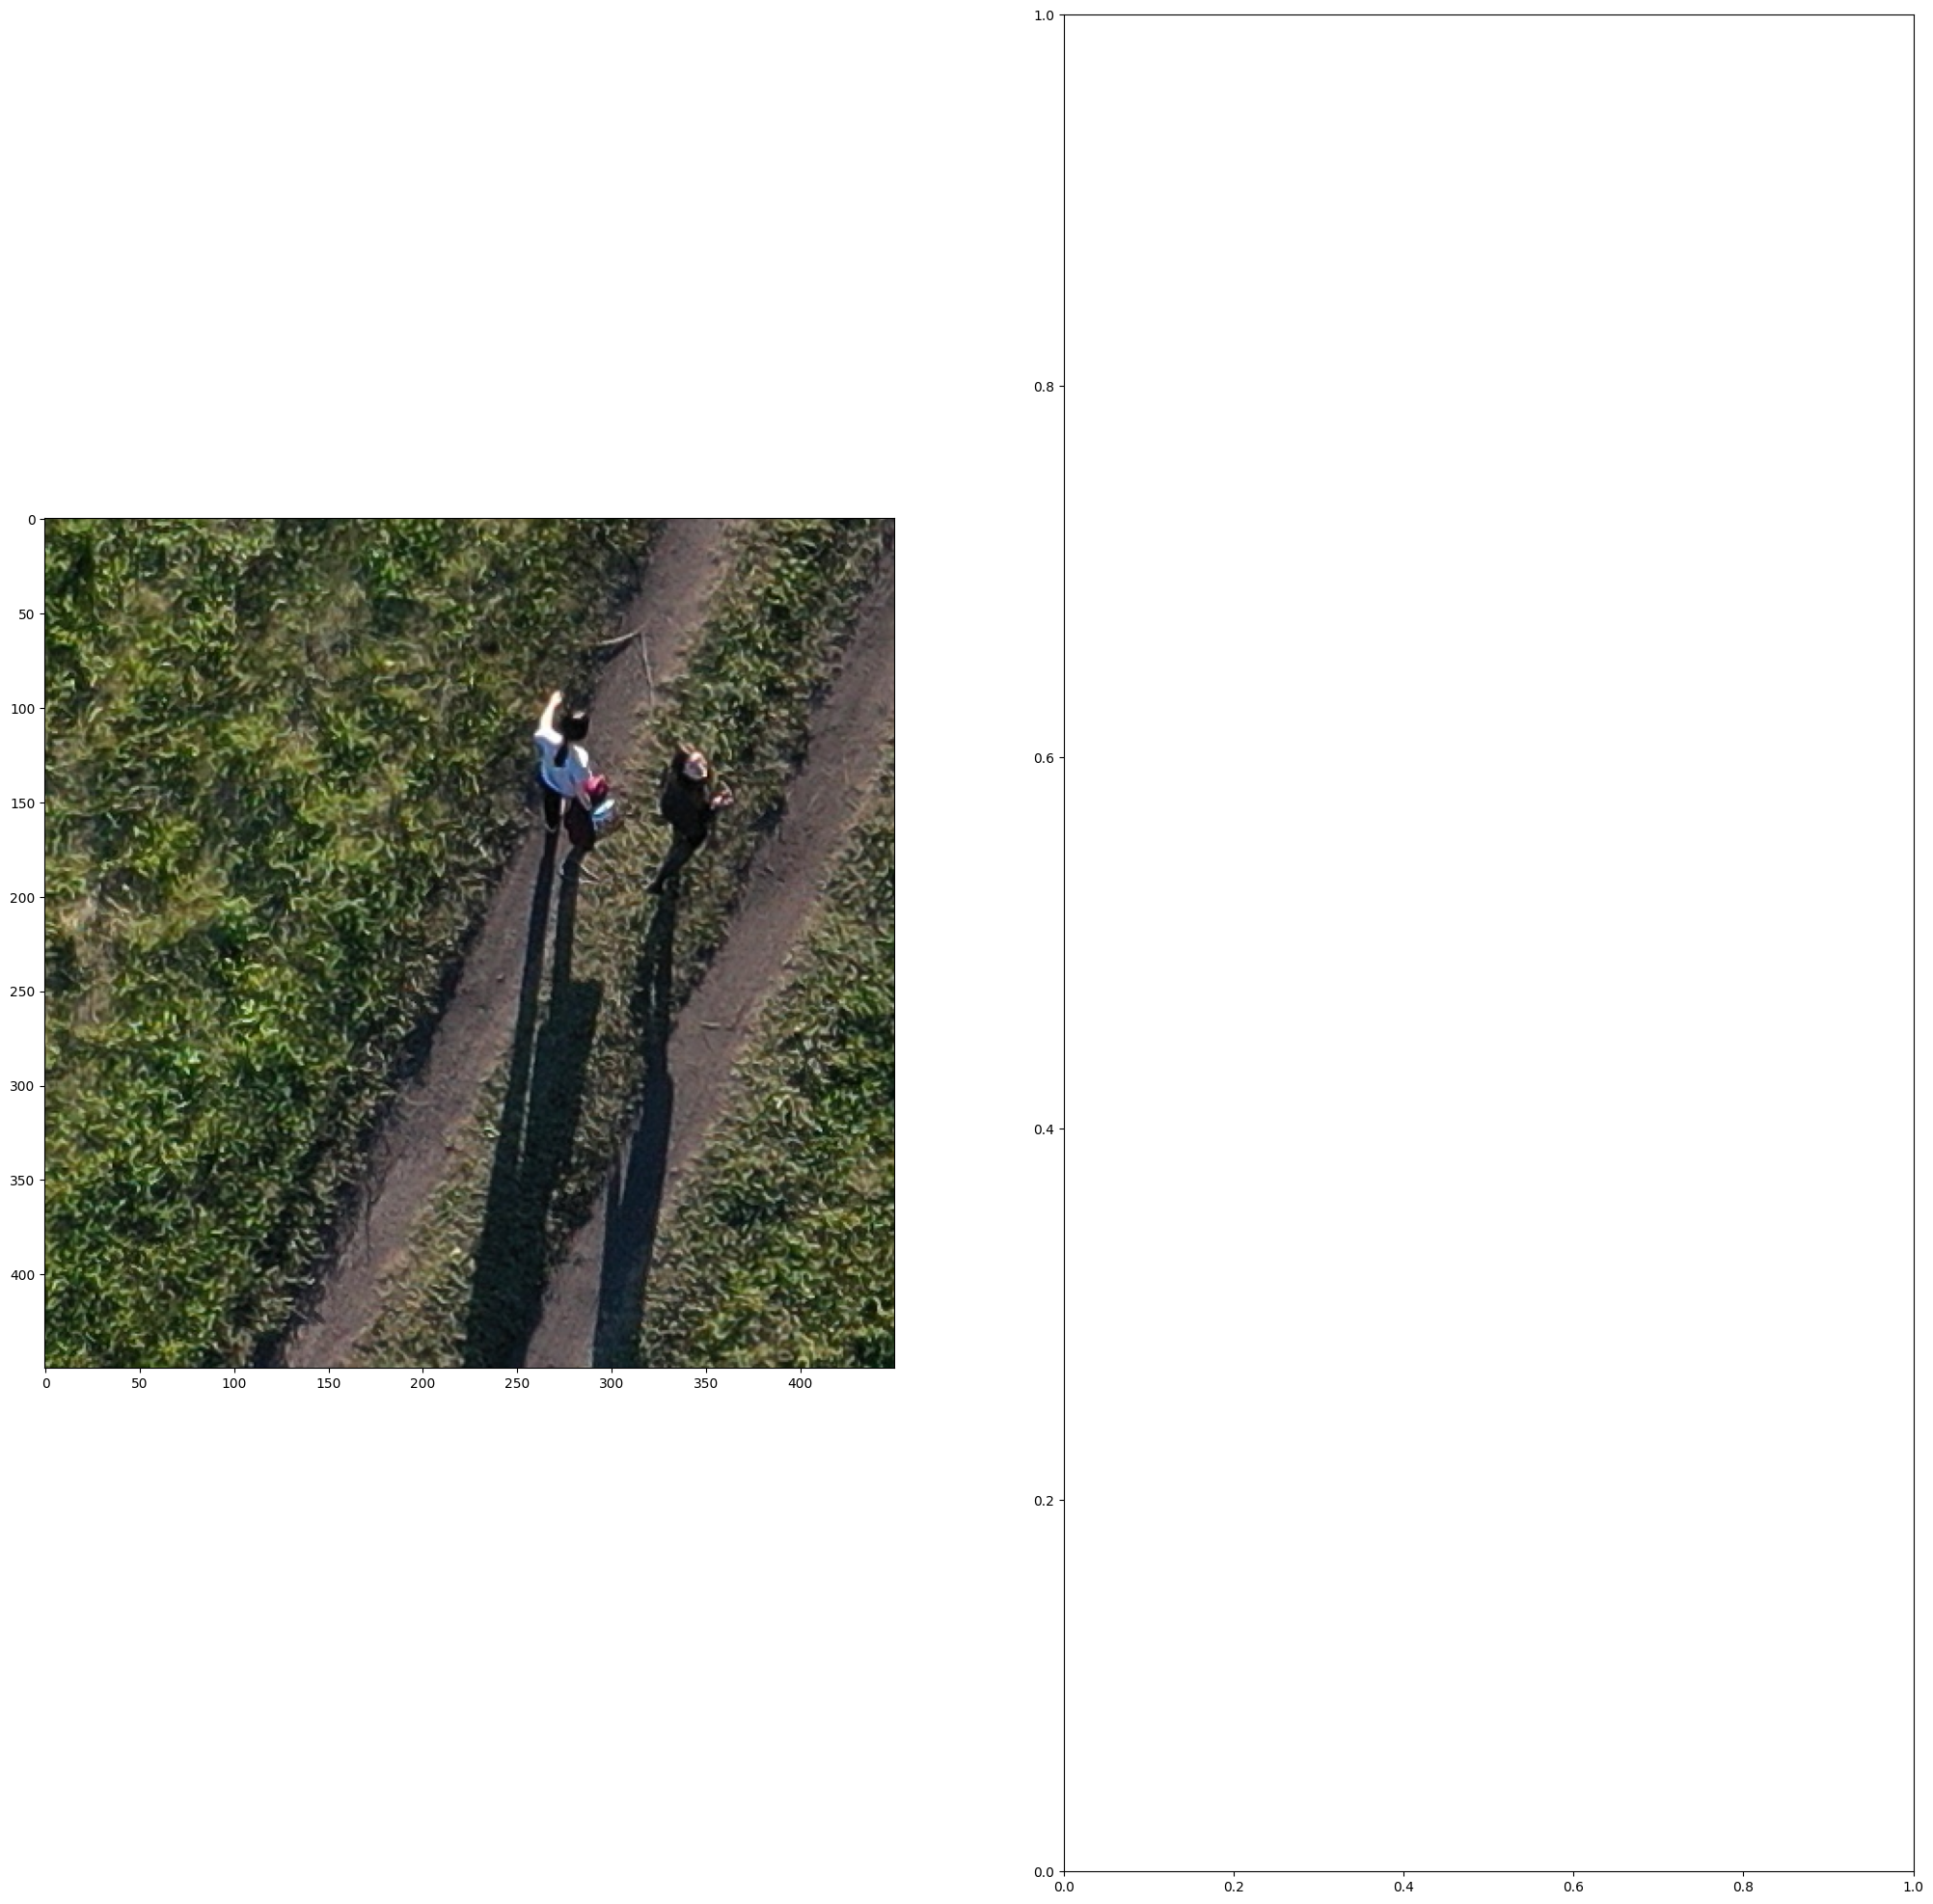

In [287]:
start_aug()